In [1]:
from tools.yields import latex_line, pretty_yield_line, signal_latex_line
from tools.analysis import measurement
from tools.sample import Sample
from tools.plotting import yields_chart, sample_pie, significance_chart, syst_yields_chart
from tools import categories
from rootpy.plotting import set_style
from rootpy.plotting.base import convert_color
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import ROOT
%matplotlib inline

Welcome to JupyROOT 6.11/02


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:253: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


In [2]:
from rootpy.io import root_open

In [3]:
channel = 'lephad'
hh_file = '/Users/quentin/cernbox/workspaces/htt_nov23/hhAll_merged_WSinput_rebinned_WithTheoryEnv_WithModJERVar.root'
lh_file = '/Users/quentin/cernbox/workspaces/htt_nov23/lephad_mh0060_MMC_rebinned_WithModJERVar_WithTheoryEnv_withWjets.root'
ll_file = '/Users/quentin/cernbox/workspaces/htt_nov23/leplep_17-12-01.all.MGZttShowerSys.mmc_mlm.rebin_WithTheoryEnv_WithModJERVar_fakes.root'

#lh_file = '~/cernbox/workspaces/htt_fine_binning/lephad_fs46_MMC_Fine_BL_WithModJERVar_WithTheoryEnv.root'
#hh_file = '~/cernbox/workspaces/htt_fine_binning/hhAll_merged_WSinput_WithTheoryEnv_WithModJERVar.root'
#ll_file = '~/cernbox/workspaces/htt_fine_binning/leplep_17-09-26.all.dilep_pt.root'


In [4]:
hh_rfile = root_open(hh_file, 'read')
lh_rfile = root_open(lh_file, 'read')
ll_rfile = root_open(ll_file, 'read')

hh_meas = measurement(hh_rfile, 'hadhad')
lh_meas = measurement(lh_rfile, 'lephad')
ll_meas = measurement(ll_rfile, 'leplep')

samples = ll_meas.backgrounds
data = ll_meas.data

hh_cats = categories['hadhad']
lh_cats = categories['lephad']
ll_cats = categories['leplep']

lh_cats_sr = categories['lephad_sr']
ll_cats_sr = categories['leplep_sr']




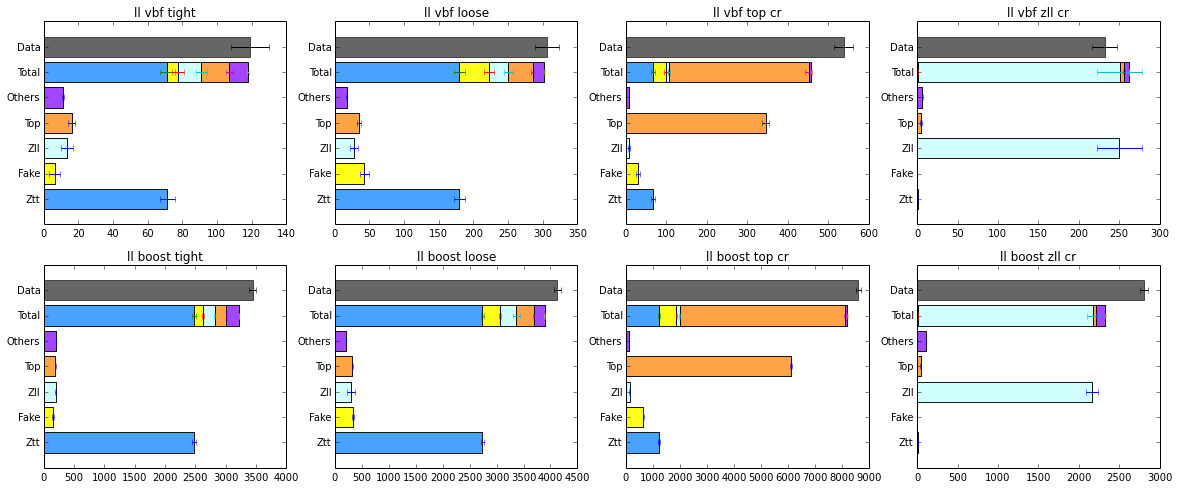

In [5]:
plt.figure(1, figsize=(20,8))
for icat, cat in enumerate(ll_cats):
    plt.subplot(2, 4, icat + 1)    
    yields_chart(ll_rfile, ll_meas.backgrounds, ll_meas.data, cat, draw_label=(icat==0 or icat==4))
    
plt.savefig('lelep_yields.pdf')

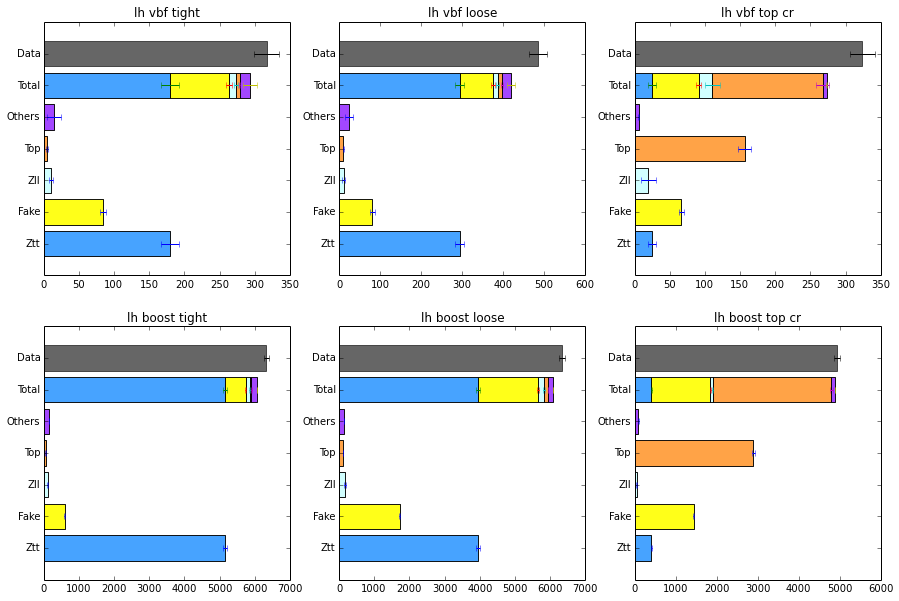

In [6]:
plt.figure(1, figsize=(15,10))
for icat, cat in enumerate(lh_cats):
    plt.subplot(2, 3, icat + 1)    
    yields_chart(lh_rfile, lh_meas.backgrounds, lh_meas.data, cat)

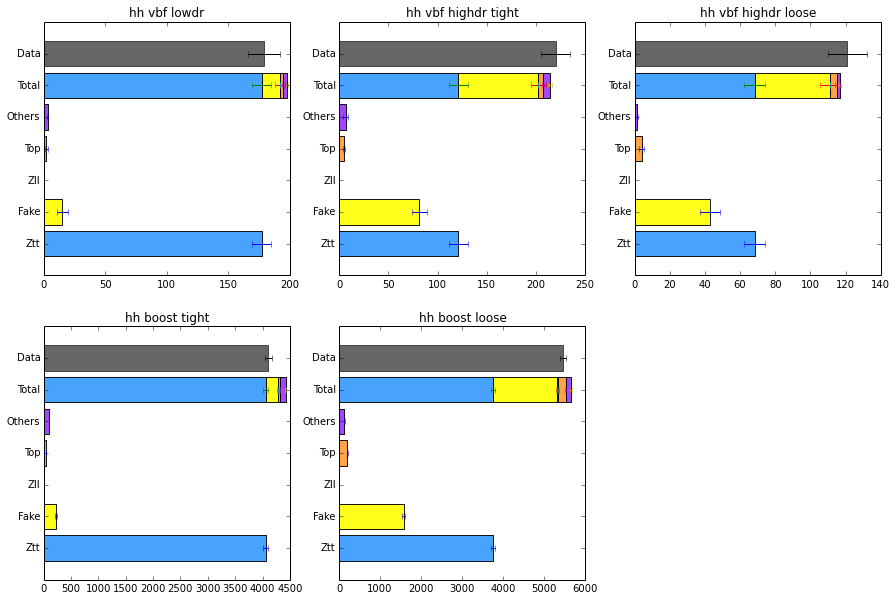

In [7]:
plt.figure(1, figsize=(15,10))
for icat, cat in enumerate(hh_cats):
    plt.subplot(2, 3, icat + 1)    
    yields_chart(hh_rfile, hh_meas.backgrounds, hh_meas.data, cat)

In [8]:
def bkg_composition_chart(ax, rfile, meas, categories, stack_start_index=0):
    
    for i_cat, cat in enumerate(categories):
        total_yield = meas.total_background.yields(rfile, cat.cats)[0]
        bottom = np.cumsum(np.array([
                        s.yields(rfile, cat.cats)[0] / total_yield for s in meas.backgrounds]),
                           axis=0)
        for i_s, sample in enumerate(meas.backgrounds):
            ax.barh(
                i_cat + stack_start_index, sample.yields(rfile, cat.cats)[0] / total_yield, 0.6,
                alpha=0.9, color=sample.color, align='center',
                left=bottom[i_s - 1] if i_s > 0 else 0)
        


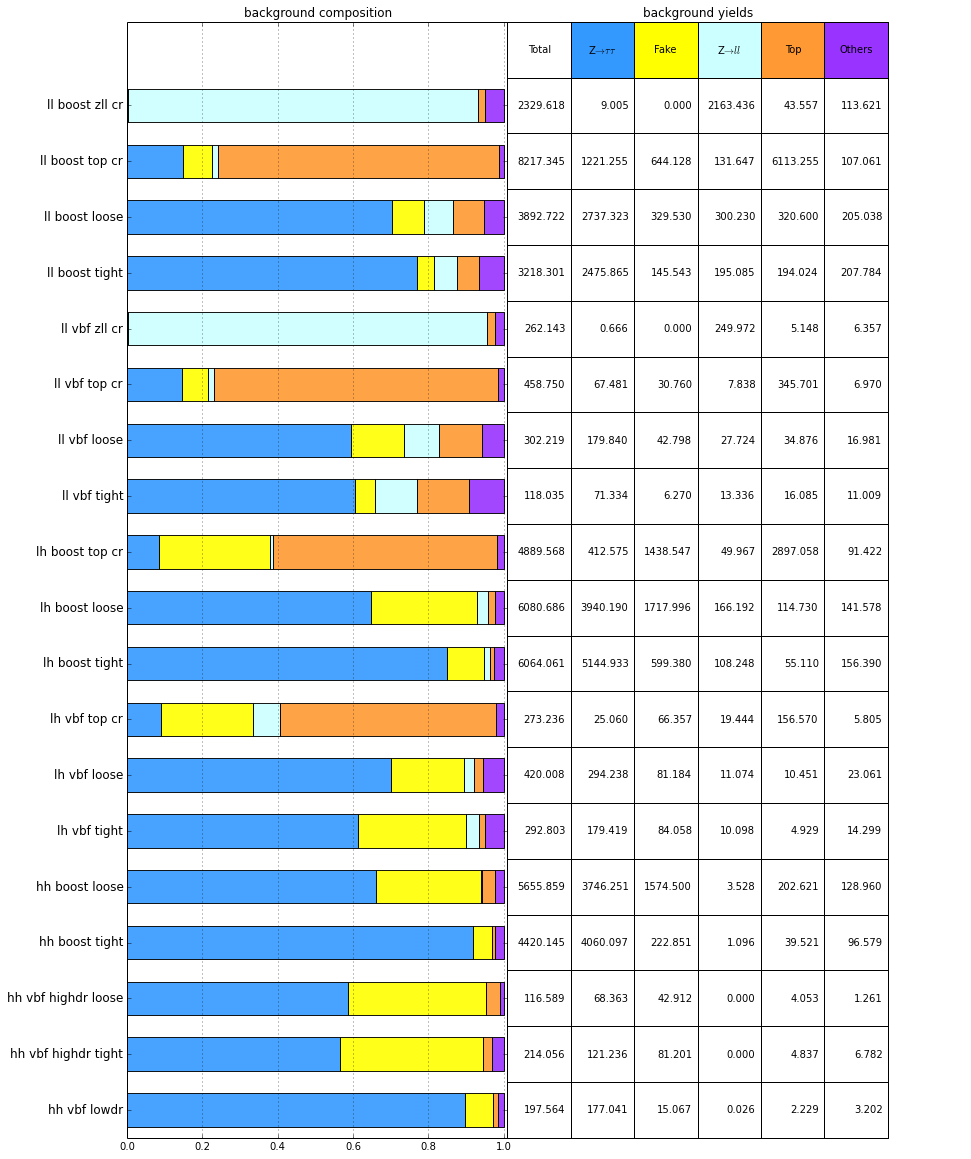

In [9]:
fig, axs = plt.subplots(1,2, figsize=(15, 20))

axs[0].grid(axis='x')
bkg_composition_chart(axs[0], hh_rfile, hh_meas, hh_cats, stack_start_index=0.5)
bkg_composition_chart(axs[0], lh_rfile, lh_meas, lh_cats, stack_start_index=len(hh_cats) + 0.5)
bkg_composition_chart(axs[0], ll_rfile, ll_meas, ll_cats, stack_start_index=len(hh_cats + lh_cats) + 0.5)
axs[0].set_yticks(np.arange(len(hh_cats + lh_cats + ll_cats)) + 0.5) 
axs[0].set_yticklabels(
    [cat.name for cat in hh_cats] + [cat.name for cat in lh_cats] + [cat.name for cat in ll_cats], 
    fontsize=12)
x_min, x_max = axs[0].get_xlim()
axs[0].set_xlim(x_min, 1.01)
axs[0].set_title('background composition')
table = []
table.append([0., 0., 0., 0., 0. , 0.])
for cat in ll_cats[::-1]:
    tot_bkg = ll_meas.total_background.yields(ll_rfile, cat.cats)[0]
    float_row = [tot_bkg] + [s.yields(ll_rfile, cat.cats)[0] for s in ll_meas.backgrounds]
    table.append(['{0:1.3f}'.format(np.round(r, decimals=3)) for r in float_row])

for cat in lh_cats[::-1]:
    tot_bkg = lh_meas.total_background.yields(lh_rfile, cat.cats)[0]
    float_row = [tot_bkg] + [s.yields(lh_rfile, cat.cats)[0] for s in lh_meas.backgrounds]
    table.append(['{0:1.3f}'.format(np.round(r, decimals=3)) for r in float_row])

for cat in hh_cats[::-1]:
    tot_bkg = hh_meas.total_background.yields(hh_rfile, cat.cats)[0]
    float_row = [tot_bkg] + [s.yields(hh_rfile, cat.cats)[0] for s in hh_meas.backgrounds]
    table.append(['{0:1.3f}'.format(np.round(r, decimals=3)) for r in float_row])

#columns = ['Total'] + [s.name if s.name != 'VV' else 'Diboson' for s in lh_meas.backgrounds]
columns = ['Total', 'Z$\\to\\tau\\tau$', 'Fake', 'Z$\\to ll$', 'Top', 'Others'] 
#columns = ['Total'] + [s.mpl_title for s in lh_meas.backgrounds]
colors = [(1., 1., 1.)] + [s.color for s in lh_meas.backgrounds]
axs[1].axis('tight')
axs[1].axis('off')
axs[1].table(cellText=table, 
          colColours=colors,
          colLabels=columns,
          loc='right', bbox = [-0.2, 0., 1., 1.],
         fontsize=40)
axs[1].set_title('background yields', x=0.3)
plt.savefig('bkg_composition.pdf')
plt.savefig('bkg_composition.eps')

In [10]:
def sig_composition_chart(ax, rfile, meas, categories, stack_start_index=0):
    
    for i_cat, cat in enumerate(categories):
        total_yield = meas.total_signal.yields(rfile, cat.cats)[0]
        bottom = np.cumsum(np.array([
                        s.yields(rfile, cat.cats)[0] / total_yield for s in meas.signals]),
                           axis=0)
        for i_s, sample in enumerate(meas.signals):
            ax.barh(
                i_cat + stack_start_index, sample.yields(rfile, cat.cats)[0] / total_yield, 0.6,
                alpha=0.9, color=sample.color, align='center',
                left=bottom[i_s - 1] if i_s > 0 else 0)
        


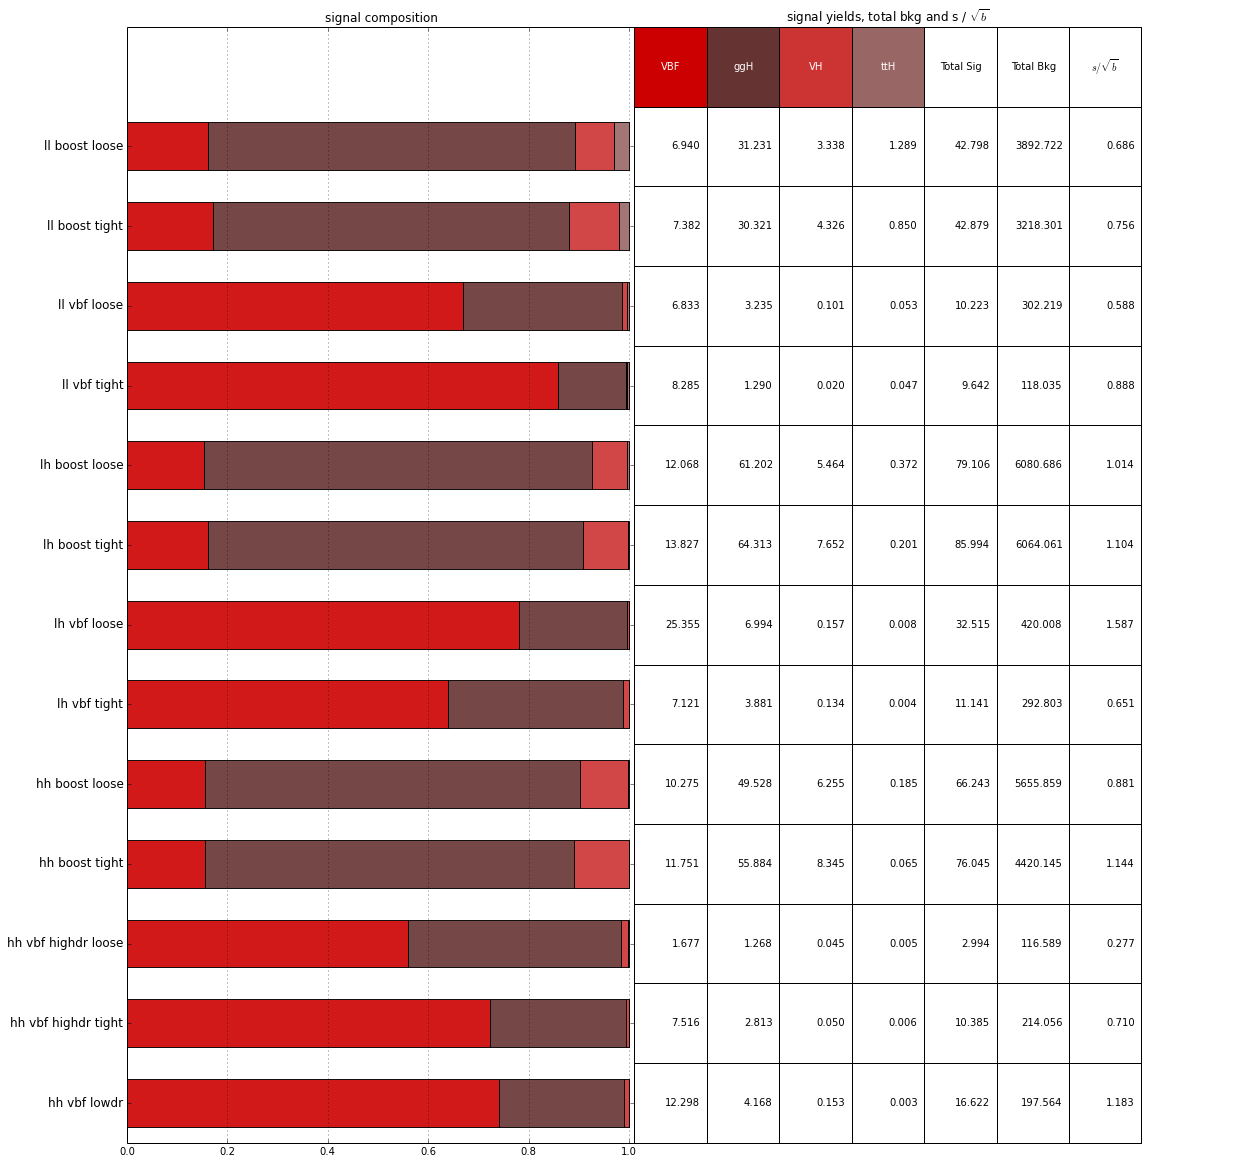

In [11]:
fig, axs = plt.subplots(1,2, figsize=(20, 20))

axs[0].grid(axis='x')
sig_composition_chart(axs[0], hh_rfile, hh_meas, hh_cats, stack_start_index=0.5)
sig_composition_chart(axs[0], lh_rfile, lh_meas, lh_cats_sr, stack_start_index=len(hh_cats) + 0.5)
sig_composition_chart(axs[0], ll_rfile, ll_meas, ll_cats_sr, stack_start_index=len(hh_cats + lh_cats_sr) + 0.5)
axs[0].set_yticks(np.arange(len(hh_cats + lh_cats_sr + ll_cats_sr)) + 0.5) 
axs[0].set_yticklabels(
    [cat.name for cat in hh_cats] + [cat.name for cat in lh_cats_sr] + [cat.name for cat in ll_cats_sr], 
    fontsize=12)
x_min, x_max = axs[0].get_xlim()
axs[0].set_xlim(x_min, 1.01)
axs[0].set_title('signal composition')
table = []
table.append([0., 0., 0., 0. , 0., 0., 0.])
for cat in ll_cats_sr[::-1]:
    tot_sig = ll_meas.total_signal.yields(ll_rfile, cat.cats)[0]
    tot_bkg = ll_meas.total_background.yields(ll_rfile, cat.cats)[0]
    float_row = [s.yields(ll_rfile, cat.cats)[0] for s in ll_meas.signals] + [tot_sig, tot_bkg, tot_sig / np.sqrt(tot_bkg)]
    table.append(['{0:1.3f}'.format(np.round(r, decimals=3)) for r in float_row])

for cat in lh_cats_sr[::-1]:
    tot_sig = lh_meas.total_signal.yields(lh_rfile, cat.cats)[0]
    tot_bkg = lh_meas.total_background.yields(lh_rfile, cat.cats)[0]
    float_row = [s.yields(lh_rfile, cat.cats)[0] for s in lh_meas.signals] + [tot_sig, tot_bkg, tot_sig / np.sqrt(tot_bkg)]
    table.append(['{0:1.3f}'.format(np.round(r, decimals=3)) for r in float_row])

for cat in hh_cats[::-1]:
    tot_sig = hh_meas.total_signal.yields(hh_rfile, cat.cats)[0]
    tot_bkg = hh_meas.total_background.yields(hh_rfile, cat.cats)[0]
    float_row = [s.yields(hh_rfile, cat.cats)[0] for s in hh_meas.signals] + [tot_sig, tot_bkg, tot_sig / np.sqrt(tot_bkg)]
    table.append(['{0:1.3f}'.format(np.round(r, decimals=3)) for r in float_row])

#columns = ['Total'] + [s.name if s.name != 'VV' else 'Diboson' for s in lh_meas.backgrounds]
columns = ['VBF', 'ggH', 'VH', 'ttH', 'Total Sig', 'Total Bkg', r'$s / \sqrt{b}$'] 
#columns = ['Total'] + [s.mpl_title for s in lh_meas.backgrounds]
colors = [s.color for s in lh_meas.signals] + [(1., 1., 1.), (1., 1., 1.), (1., 1., 1.)]
axs[1].axis('tight')
axs[1].axis('off')
a = axs[1].table(cellText=table, 
          colColours=colors,
          colLabels=columns,
          loc='right', bbox = [-0.2, 0., 1., 1.])
a._cells[(0, 0)]._text.set_color('white')
a._cells[(0, 1)]._text.set_color('white')
a._cells[(0, 2)]._text.set_color('white')
a._cells[(0, 3)]._text.set_color('white')

axs[1].set_title(r'signal yields, total bkg and s / $\sqrt{b}$', x=0.3)
plt.savefig('signal_composition.eps')
plt.savefig('signal_composition.pdf')